In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Total requests per load balancing strategy.
# The values were determined from the CSV output data,
# by adding the number of completed requests to the number of pending VUs
# that had not finished their requests by the end of the test.
total_requests = {
    "Single Host": 60,
    "Round Robin": 60,
    "Least Connection": 60,
    "ollamaFlow": 61,
}

In [3]:
# Read the CSV file into a DataFrame
files = {
    "Single Host": "result-single-host/test.csv",
    "Round Robin": "result-roundrobin/test.csv",
    "Least Connection": "result-leastconn/test.csv",
    "ollamaFlow": "result-ollamaflow/test.csv",
}
dfs = []
for source, file_path in files.items():
    df_temp = pd.read_csv(file_path)
    df_temp['source'] = source
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

In [4]:
# Convert the 'timestamp' column from Unix epoch to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [5]:
# Calculate elapsed time in minutes since the first timestamp
df['elapsed_seconds'] = (
    df.groupby('source')['timestamp']
      .transform(lambda x: (x - x.min()).dt.total_seconds())
)
df['elapsed_minutes'] = df['elapsed_seconds'] / 60.0

In [6]:
# Filter for 'http_reqs' metric only
df = df[df['metric_name'] == 'http_reqs']

# Calculate cumulative completed requests and percent complete
df['completed_request'] = (
    df.groupby('source')['metric_value']
      .cumsum()
)

df['percent_complete'] = df.apply(
    lambda row: (row['completed_request'] / total_requests[row['source']]) * 100,
    axis=1
)

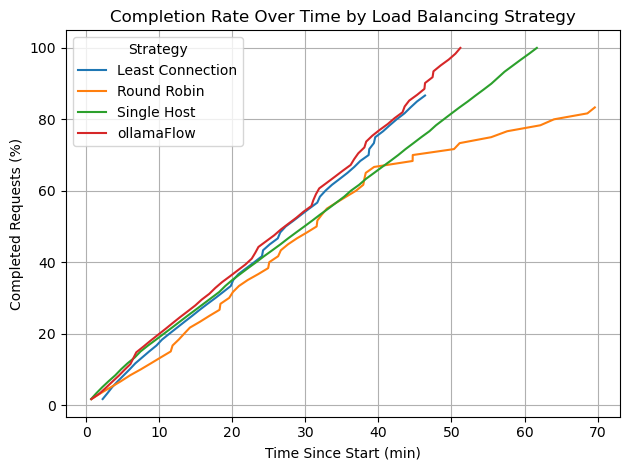

In [7]:
# Plotting
plt.figure()
for source, subset in df.groupby('source'):
    plt.plot(subset['elapsed_minutes'], subset['percent_complete'], label=source)

plt.xlabel('Time Since Start (min)')
plt.ylabel('Completed Requests (%)')
plt.title('Completion Rate Over Time by Load Balancing Strategy')
plt.legend(title='Strategy')
plt.grid(True)
plt.tight_layout()
plt.show()